# Classify names with character n-grams

In [46]:
from argparse import Namespace

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook

%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 6)

## Overview of Data/Task
- Data compiled by [Sean Robertson](https://github.com/spro)
- Predict nationality from names.
- Data consist of 20074 names, 18 categories. 
- Russian names are dominant (skewing labels)
  - We downsample russian names to minimize the skew. Checkout the RNN tutorial for a different approach to handle label bias.

```
    2750 names_test.csv
   10994 names_train.csv
```

### Args for this example

In [47]:
args = Namespace(
    surname_csv="../data/surnames.csv",
    model_filename="names_mlp_model.pth",
    cuda=False,
    num_epochs=100
)


# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

print("Using CUDA: {}".format(args.cuda))

args.device = torch.device("cuda" if args.cuda else "cpu")
args.device

Using CUDA: False


device(type='cpu')

## Load names

In [50]:
name_data = pd.read_csv(args.surname_csv)
name_data[0:3]

,split,surname,nationality
0,train,Hadad,arabic
1,train,Prikazchikov,russian
2,train,Bajov,russian


## Class Breakdown

Highly imbalanced dataset with Russian having the most


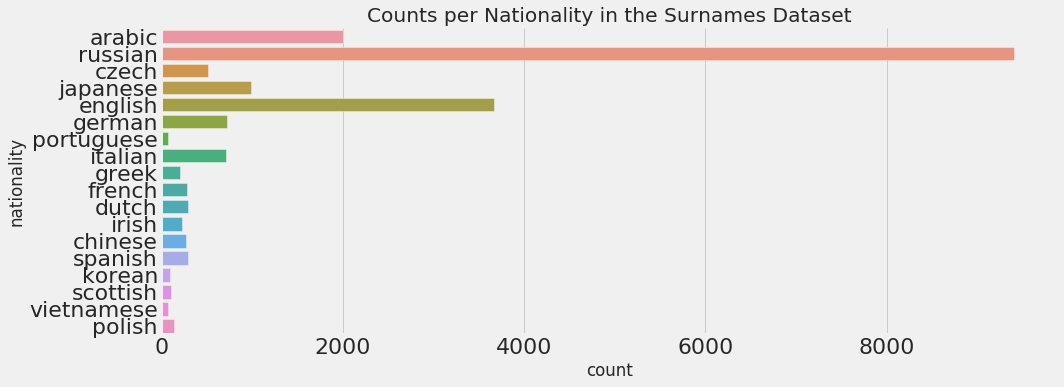

In [53]:
sns.catplot(data=name_data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset");
print("Highly imbalanced dataset with Russian having the most")

In [56]:
def fix_imbalance(df):
    median = df.groupby('nationality').agg('count').split.median()
    print("Median: ", median)
    for nationality in df.nationality.unique():
        
        df_main = df[df.nationality != nationality]
        df_sub = df[df.nationality == nationality].reset_index(drop=True)
        if len(df_sub) > median:
            size = min(len(df_sub), int(median+0.05*len(df_sub)))
            indices = np.random.choice(np.arange(len(df_sub)), 
                                       size=size, 
                                       replace=False)
            df_sub = df_sub.iloc[indices]
        df = pd.concat([df_main, df_sub]).reset_index(drop=True)
    return df

Median:  287.0


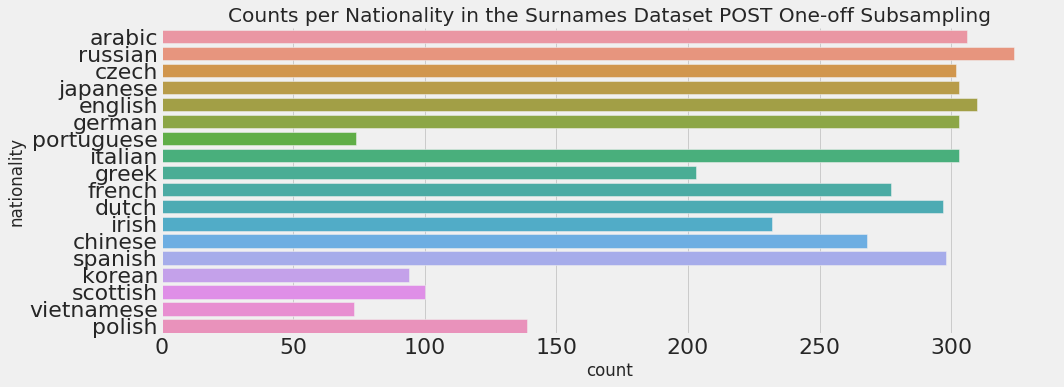

In [57]:
name_data = fix_imbalance(name_data)
sns.catplot(data=name_data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Dataset POST One-off Subsampling");

# Feature Engineering

## 1. Lowercase

In [58]:
name_data['features'] = name_data['surname'].apply(lambda x: x.lower())
name_data.head()

,split,surname,nationality,features
0,test,Said,arabic,said
1,train,Khoury,arabic,khoury
2,train,Srour,arabic,srour
3,train,Zogby,arabic,zogby
4,train,Shalhoub,arabic,shalhoub


## 2. Add begin and end tokens


In [59]:
def add_begin_end_tokens(name):
    # return "^{}$".format(name)
    begin_token_marker = "^"
    end_token_marker = '$'
    return "".join((begin_token_marker, name, end_token_marker))

In [60]:
name_data['features'] = name_data['features'].apply(add_begin_end_tokens)
name_data.head()

,split,surname,nationality,features
0,test,Said,arabic,^said$
1,train,Khoury,arabic,^khoury$
2,train,Srour,arabic,^srour$
3,train,Zogby,arabic,^zogby$
4,train,Shalhoub,arabic,^shalhoub$


## 3. Extract Character N-grams

In [61]:
def extract_n_grams(tokens, n):
    '''
    param tokens: tokenized text
    return: list of n grams
    '''
    return [tokens[i:i + n] for i in range(len(tokens) - n + 1)]

In [62]:
# use trigrams
name_data['features'] = name_data['features'].apply(lambda x: extract_n_grams(x, 3))
name_data.head()

,split,surname,nationality,features
0,test,Said,arabic,"[^sa, sai, aid, id$]"
1,train,Khoury,arabic,"[^kh, kho, hou, our, ury, ry$]"
2,train,Srour,arabic,"[^sr, sro, rou, our, ur$]"
3,train,Zogby,arabic,"[^zo, zog, ogb, gby, by$]"
4,train,Shalhoub,arabic,"[^sh, sha, hal, alh, lho, hou, oub, ub$]"


## 4. Build vocabulary

In [63]:
vocabulary  = set()
for name in name_data['features'].values:
    [vocabulary.add(ngram) for ngram in name]        

In [64]:
maxlen = max(name_data['features'].apply(len))
maxlen

18

## 5. Map n-grams to indices

In [65]:
ngram_to_index = {ngram:i for i, ngram in enumerate(vocabulary, 1)}

In [66]:
def n_grams_to_indices(n_grams):
    unknown_index = len(ngram_to_index) + 1
    return [ngram_to_index.get(ngram, unknown_index) for ngram in n_grams]  

In [67]:
n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])

[1608, 2361, 3106, 2056, 3436]

## 6. Pad indices

In [68]:
def pad_indices(indices, maxlen=20):
    padded = np.zeros(maxlen, dtype=np.int64)
    for i, index in enumerate(indices):
        padded[i] = index
    return padded 

In [69]:
test_name = n_grams_to_indices(['^ha', 'had', 'ada', 'dad', 'ad$'])
pad_indices(test_name, 20)

array([1608, 2361, 3106, 2056, 3436,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0])

## 7. Encode class labels as numbers

In [70]:
label_to_number = {y: i for i, y in enumerate(sorted(set(name_data['nationality'])))}
number_to_label = {i: y for i, y in enumerate(sorted(set(name_data['nationality'])))}

In [71]:
label_to_number

{'arabic': 0,
 'chinese': 1,
 'czech': 2,
 'dutch': 3,
 'english': 4,
 'french': 5,
 'german': 6,
 'greek': 7,
 'irish': 8,
 'italian': 9,
 'japanese': 10,
 'korean': 11,
 'polish': 12,
 'portuguese': 13,
 'russian': 14,
 'scottish': 15,
 'spanish': 16,
 'vietnamese': 17}

## 8. Consolidate data preperation pipeline

In [ ]:
def extract_name_features(name, n_grams=3):
    """
    Applies feature extraction pipeline to name
    """
    features = name.lower()
#     print(features)
    features = add_begin_end_tokens(features)
#     print(features)
    features = extract_n_grams(features, n_grams)
#     print(features)    
    features = n_grams_to_indices(features)
#     print(features)    
    features = pad_indices(features)
#     print(features)    
    features = torch.from_numpy(features).long()
    return features

In [ ]:
extract_name_features('Brian')

## Create PyTorch Dataset

In [ ]:
class VectorizedSurnames(Dataset):
    """Name Classification dataset"""

    def __init__(self, data):
        '''
        Args:
            data (pandas.DataFrame)
        '''
        self.data = data
        self.x_surnames = self.data['surname'].apply(lambda x: extract_name_features(x, 3))
        self.y_nationalities = self.data['nationality'].apply(lambda x: label_to_number[x])

    @classmethod
    def from_file(cls, filename, split='train', apply_fix=True):
        df = pd.read_csv(filename).dropna()
        df = df[df.split == split]
        if apply_fix:
            df = fix_imbalance(df)
        return cls(df)
    
    def __len__(self):
        return len(self.x_surnames)

    def __getitem__(self, index):
        return {'x_surnames': self.x_surnames.iloc[index],
                'y_nationalities': self.y_nationalities.iloc[index]}

In [ ]:
name_dataset = VectorizedSurnames.from_file(args.surname_csv, split='train', apply_fix=True)

In [ ]:
# index first into the __getitem__ above and then into the resulting dictionary
name_dataset[0]['x_surnames'].type()

In [ ]:
dataloader = DataLoader(name_dataset, batch_size=32, shuffle=True)
#jax

## Define MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_size, maxlen, dropout_p=0.5):
        super(MLP, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.fc1 = nn.Linear(embedding_dim * maxlen, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self._dropout_p = dropout_p

    def forward(self, x, apply_softmax=False):
        x = self.embeddings(x).view(-1, (embedding_dim * maxlen))
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self._dropout_p)
        x = self.fc2(x)
        if apply_softmax:
            x = F.softmax(x, dim=1)
        return x
    
#     def forward(self,x,apply_softmax=False):
#         x=self.embeddings(x)
#         x=F.relu()

In [ ]:
vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 2 # hidden dim.
hidden_dim = 500
output_size = len(label_to_number) # number of classes
maxlen = 1

classifier = MLP(vocab_size, embedding_dim, hidden_dim, output_size, maxlen)

In [ ]:
batch_dict['x_surnames'].shape

In [ ]:
classifier.embeddings(batch_dict['x_surnames']).shape

## Train

In [ ]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

In [ ]:
args.num_epochs=400
classifier = classifier.to(args.device)

optimizer = optim.Adam(classifier.parameters())
criterion = nn.CrossEntropyLoss()

loss_history = []
accuracy_history = []

epoch_bar = tqdm_notebook(desc='epochs', total=args.num_epochs)

try:
    for _ in range(args.num_epochs):
        per_epoch_losses = []
        per_epoch_accuracy = []
        for batch in dataloader:
            # Step 1: clear the gradients 
            optimizer.zero_grad()

            # Step 2: apply the model to the data
            x_surnames = batch['x_surnames'].to(args.device)
            y_nationalities = batch['y_nationalities'].to(args.device)

            y_prediction = classifier(x_surnames)

            # Step 3: compute the loss and propagate the gradients
            
            loss = criterion(y_prediction, y_nationalities)
            loss.backward()

            # Step 4; have optimizer update the model weights
            optimizer.step()
            
            # bonus steps:  bookkeeping
            
            per_epoch_losses.append(loss.item())
            
            accuracy = compute_accuracy(y_prediction, y_nationalities)
            per_epoch_accuracy.append(accuracy)
            


        loss_history.append(np.mean(per_epoch_losses))
        accuracy_history.append(np.mean(per_epoch_accuracy))
        epoch_bar.set_postfix(loss=loss_history[-1], accuracy=accuracy_history[-1])
        epoch_bar.update()
except KeyboardInterrupt:
    print("...")

In [ ]:
_, ax = plt.subplots(1, 1)
ax.plot(loss_history, color='#942174', label='loss')
plt.legend(bbox_to_anchor=(0.86, 0.7))
ax.grid(False)
ax.set_xlabel("Epoch Index")
ax.set_ylabel("Loss Value")
ax2 = plt.twinx()
ax2.set_ylabel("Accuracy Value")
ax2.plot(accuracy_history, color='#e5a930', label='accuracy')
plt.legend(bbox_to_anchor=(0.9, 0.8))

## save model

In [161]:
torch.save(classifier.state_dict(), args.model_filename)

## load model

In [162]:
classifier.load_state_dict(torch.load(args.model_filename))

## Evaluate on test set

In [163]:
# args.device = "cuda"
args.device = "cpu"

In [165]:
from sklearn.metrics import confusion_matrix, accuracy_score

name_dataset_test = VectorizedSurnames.from_file(args.surname_csv, split='test')
dataloader_test = DataLoader(name_dataset_test, batch_size=16, shuffle=True, num_workers=0)

classifier = classifier.to(args.device)

classifier.eval()

ground_truth = []
predictions = []
for batch in dataloader:
    x_surnames = batch['x_surnames'].to(args.device)
    y_nationalities = batch['y_nationalities'].to(args.device)

    
    outputs = classifier(x_surnames)
    
    y_pred_probabilities, y_pred_indices = torch.max(outputs, dim=1)
    
    ground_truth.append(y_nationalities.detach().cpu().numpy())
    predictions.append(y_pred_indices.detach().cpu().squeeze().numpy())
    
ground_truth = np.concatenate(ground_truth)
predictions = np.concatenate(predictions)

print(accuracy_score(ground_truth, predictions)) 

Median:  60.5
petersen
^petersen$
['^pe', 'pet', 'ete', 'ter', 'ers', 'rse', 'sen', 'en$']
[3115, 959, 3271, 2605, 3364, 17, 989, 763]
[3115  959 3271 2605 3364   17  989  763    0    0    0    0    0    0
    0    0    0    0    0    0]
mcnally
^mcnally$
['^mc', 'mcn', 'cna', 'nal', 'all', 'lly', 'ly$']
[628, 4150, 3795, 1051, 3279, 700, 474]
[ 628 4150 3795 1051 3279  700  474    0    0    0    0    0    0    0
    0    0    0    0    0    0]
greenleaf
^greenleaf$
['^gr', 'gre', 'ree', 'een', 'enl', 'nle', 'lea', 'eaf', 'af$']
[819, 3028, 1412, 1024, 162, 2114, 1628, 4575, 3008]
[ 819 3028 1412 1024  162 2114 1628 4575 3008    0    0    0    0    0
    0    0    0    0    0    0]
plastow
^plastow$
['^pl', 'pla', 'las', 'ast', 'sto', 'tow', 'ow$']
[399, 3728, 4156, 2823, 1745, 3425, 1440]
[ 399 3728 4156 2823 1745 3425 1440    0    0    0    0    0    0    0
    0    0    0    0    0    0]
brain
^brain$
['^br', 'bra', 'rai', 'ain', 'in$']
[1620, 1235, 1841, 3692, 3211]
[1620 1235 1841

    0    0    0    0    0    0]
halevin
^halevin$
['^ha', 'hal', 'ale', 'lev', 'evi', 'vin', 'in$']
[1608, 3397, 1236, 1924, 3956, 3123, 3211]
[1608 3397 1236 1924 3956 3123 3211    0    0    0    0    0    0    0
    0    0    0    0    0    0]
moltenskoi
^moltenskoi$
['^mo', 'mol', 'olt', 'lte', 'ten', 'ens', 'nsk', 'sko', 'koi', 'oi$']
[3411, 2462, 3486, 4090, 473, 2915, 1313, 477, 892, 571]
[3411 2462 3486 4090  473 2915 1313  477  892  571    0    0    0    0
    0    0    0    0    0    0]
jamburg
^jamburg$
['^ja', 'jam', 'amb', 'mbu', 'bur', 'urg', 'rg$']
[3342, 2855, 2785, 4575, 3378, 3071, 3429]
[3342 2855 2785 4575 3378 3071 3429    0    0    0    0    0    0    0
    0    0    0    0    0    0]
zhituhin
^zhituhin$
['^zh', 'zhi', 'hit', 'itu', 'tuh', 'uhi', 'hin', 'in$']
[1759, 3790, 2304, 1477, 1564, 3125, 147, 3211]
[1759 3790 2304 1477 1564 3125  147 3211    0    0    0    0    0    0
    0    0    0    0    0    0]
esenkov
^esenkov$
['^es', 'ese', 'sen', 'enk', 'nko', 'ko

^ganem$
['^ga', 'gan', 'ane', 'nem', 'em$']
[4260, 697, 5, 1721, 1376]
[4260  697    5 1721 1376    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
kassis
^kassis$
['^ka', 'kas', 'ass', 'ssi', 'sis', 'is$']
[2967, 2131, 143, 3926, 3496, 2003]
[2967 2131  143 3926 3496 2003    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
basara
^basara$
['^ba', 'bas', 'asa', 'sar', 'ara', 'ra$']
[2152, 1911, 1640, 873, 4394, 3787]
[2152 1911 1640  873 4394 3787    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
tahan
^tahan$
['^ta', 'tah', 'aha', 'han', 'an$']
[4249, 2441, 1045, 4560, 641]
[4249 2441 1045 4560  641    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
samaha
^samaha$
['^sa', 'sam', 'ama', 'mah', 'aha', 'ha$']
[3996, 957, 2069, 4121, 1045, 217]
[3996  957 2069 4121 1045  217    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
gerges
^gerges$
['^ge', 'ger', 'erg', 'rge', 'ges'

['^al', 'als', 'lst', 'st$']
[2434, 482, 904, 229]
[2434  482  904  229    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
aarle
^aarle$
['^aa', 'aar', 'arl', 'rle', 'le$']
[2013, 3428, 4521, 1698, 1146]
[2013 3428 4521 1698 1146    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
amersvoort
^amersvoort$
['^am', 'ame', 'mer', 'ers', 'rsv', 'svo', 'voo', 'oor', 'ort', 'rt$']
[846, 4422, 2040, 3364, 1082, 732, 2314, 2985, 3173, 960]
[ 846 4422 2040 3364 1082  732 2314 2985 3173  960    0    0    0    0
    0    0    0    0    0    0]
haanrade
^haanrade$
['^ha', 'haa', 'aan', 'anr', 'nra', 'rad', 'ade', 'de$']
[1608, 1297, 2203, 1398, 3934, 1769, 781, 2478]
[1608 1297 2203 1398 3934 1769  781 2478    0    0    0    0    0    0
    0    0    0    0    0    0]
ramakers
^ramakers$
['^ra', 'ram', 'ama', 'mak', 'ake', 'ker', 'ers', 'rs$']
[693, 4210, 2069, 4098, 4500, 1578, 3364, 1842]
[ 693 4210 2069 4098 4500 1578 3364 1842    0    0   

    0    0    0    0    0    0]
sargent
^sargent$
['^sa', 'sar', 'arg', 'rge', 'gen', 'ent', 'nt$']
[3996, 873, 1746, 4118, 2531, 1984, 4000]
[3996  873 1746 4118 2531 1984 4000    0    0    0    0    0    0    0
    0    0    0    0    0    0]
girard
^girard$
['^gi', 'gir', 'ira', 'rar', 'ard', 'rd$']
[2822, 3081, 3885, 3595, 1458, 1456]
[2822 3081 3885 3595 1458 1456    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
villeneuve
^villeneuve$
['^vi', 'vil', 'ill', 'lle', 'len', 'ene', 'neu', 'euv', 'uve', 've$']
[235, 1086, 2216, 32, 844, 3068, 2177, 4535, 558, 3233]
[ 235 1086 2216   32  844 3068 2177 4535  558 3233    0    0    0    0
    0    0    0    0    0    0]
poulin
^poulin$
['^po', 'pou', 'oul', 'uli', 'lin', 'in$']
[2193, 4417, 3093, 894, 69, 3211]
[2193 4417 3093  894   69 3211    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]
bureau
^bureau$
['^bu', 'bur', 'ure', 'rea', 'eau', 'au$']
[2419, 3378, 3471, 2195, 48, 3467]
[2419 3378 3

0.9654471544715447


Text(0.5, 1.0, 'Counts per Nationality in the Surnames Test Set')

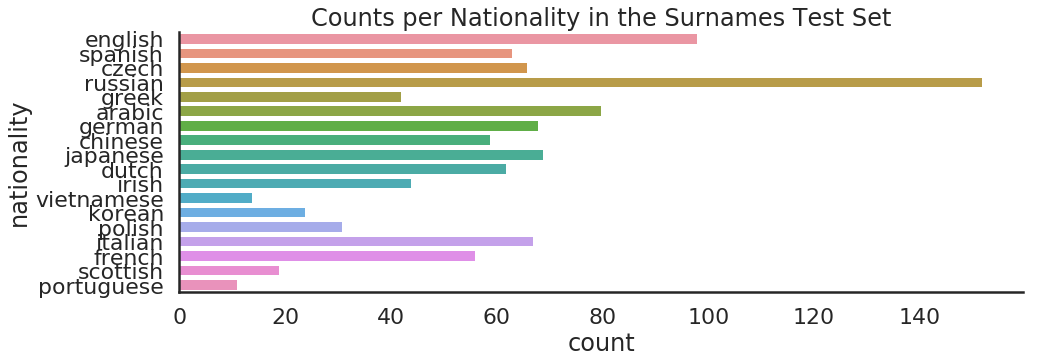

In [166]:
sns.catplot(data=name_dataset_test.data, y='nationality', 
               kind='count', height=5, aspect=3);
plt.title("Counts per Nationality in the Surnames Test Set")

In [167]:
labels = name_dataset_test.data.nationality.values

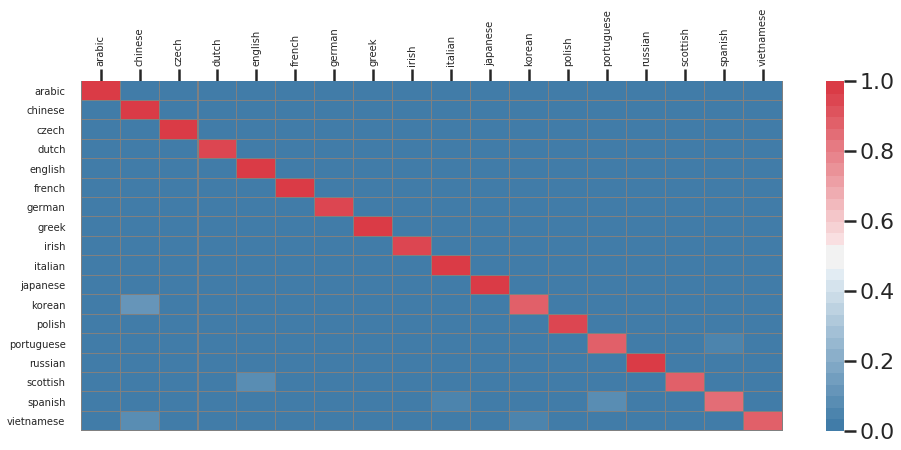

In [168]:
sns.set_style('white')
sns.set_context('poster')
labels = [number_to_label[i] for i in range(len(number_to_label))]
cm = confusion_matrix(ground_truth, predictions).astype(np.float32)
cm /= cm.sum(axis=1, keepdims=True)
g = sns.heatmap(cm, 
                cmap=sns.diverging_palette(240, 10, n=30), 
                center=0.5,
                linewidths=0.01, 
                linecolor='gray');
g.xaxis.tick_top()
g.set_xticks([0.5 + i for i in range(len(labels))])
g.set_yticks([0.5 + i for i in range(len(labels))])
g.set_xticklabels(labels, rotation=90, size=10);
g.set_yticklabels(labels, rotation=0, size=10);


## Exercise: run your name through the model

In [142]:
name = extract_name_features('lim')
name = name.view(1,-1) # reshape because model expects a batch

prediction = classifier(name.to(args.device), apply_softmax=True)
top_pred, index = torch.max(prediction, dim=1)
number_to_label[index[0].item()]

lim
^lim$
['^li', 'lim', 'im$']
[3826, 3993, 2914]
[3826 3993 2914    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]


'korean'

vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 200 # hidden dim.
hidden_dim = 200
output_size = len(label_to_number) # number of classes
maxlen = 20
0.9654471544715447

vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 200 # hidden dim.
hidden_dim = 400
output_size = len(label_to_number) # number of classes
maxlen = 20

vocab_size = len(vocabulary) + 2 # one for unknown index
embedding_dim = 400 # hidden dim.
hidden_dim = 200
output_size = len(label_to_number) # number of classes
maxlen = 20
